In [ ]:
# default_exp

# Creating Ambiguous-MNIST for Dirty-MNIST
> Synthesizing an ambiguous version of MNIST step-by-step.

Please cite us:

```
@article{mukhoti2021deterministic,
  title={Deterministic Neural Networks with Appropriate Inductive Biases Capture Epistemic and Aleatoric Uncertainty},
  author={Mukhoti, Jishnu and Kirsch, Andreas and van Amersfoort, Joost and Torr, Philip HS and Gal, Yarin},
  journal={arXiv preprint arXiv:2102.11582},
  year={2021}
}
```

You can find the paper here: https://arxiv.org/abs/2102.11582.

In [ ]:
# hide
# all_slow
from nbdev.showdoc import *

%config Completer.use_jedi = False

## Overview

We train a VAE on the original MNIST dataset to be able to synthesize new MNIST digits. Then, we train an ensemble of LeNet models on MNIST that we can use to select ambiguous samples (low epistemic uncertainty, high aleatoric uncertainty) from the VAE.

To calibrate the VAE's output to match MNIST's unwhitened outputs as much as possible, we synthesize unambiguous digits using the VAE first and then adjust the outputs slightly.

To cover a wider range of entropies, we employ stratified sampling of ambiguous samples while rejecting samples with high epistemic uncertainty (info gain).

We try to different means of sampling from the VAE. The first one samples randomly from the latent space (unit Gaussian). The other method encodes existing MNIST samples into the latent space and then interpolates between them, using Barycentric coordinates. I.e. by randomly picking a convex interpolation.

### Software Engineering

To save progress and resources, the script caches most results locally using a helper function `restore_or_create`. We did not upload the cache here&mdash;you can generate it yourself if you wish so. We only upload to this website the final AMNIST samples.

## Prerequisites

In [ ]:
import os
from functools import wraps

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

# Setup matplotlib to make it easier to copy outputs into Slack (seriously).
plt.rcParams["figure.facecolor"] = "white"

batch_size = 128

Load MNIST:

In [ ]:
mnist_mean, mnist_std = 0.1307, 0.3081

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mnist_mean,), (mnist_std,))])

mnist_train_dataset = datasets.MNIST(root="./mnist_data/", train=True, transform=transform, download=True)
mnist_test_dataset = datasets.MNIST(root="./mnist_data/", train=False, transform=transform, download=True)

mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset, batch_size=batch_size, shuffle=False)

Two helper functions to normalize and unnormalize MNIST samples. MNIST samples are stored as grayscale bytes in a range 0..255, which is first converted to 0..1 floats by the MNIST dataset code in `torchvision`. We then normalize the values further to have zero mean and standard deviation 1, which helps with training.

In [ ]:
def unnormalize_mnist(x):
    return x * mnist_std + mnist_mean

In [ ]:
def normalize_mnist(x):
    return (x - mnist_mean) / mnist_std

Finally, we need a helper function to make it easy to backup and restore resources:

In [ ]:
def restore_or_create(file_or_path, recreate: bool = False, *, pickle_module=None, pickle_load_args={}):
    pickle_module_arg = dict(pickle_module=pickle_module) if pickle_module else {}

    def delegate(func):
        @wraps(func)
        def wrapper():
            if not recreate:
                try:
                    return torch.load(file_or_path, {**pickle_load_args, **pickle_module_arg})
                except FileNotFoundError:
                    pass
            result = func()
            torch.save(result, file_or_path, pickle_protocol=-1, **pickle_module_arg)
            return result

        return wrapper

    return delegate

## VAE Code

This code is from https://github.com/pytorch/examples/blob/master/vae/main.py.

Note, we train it on whitened MNIST, and have adapted the loss function for that.

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return (F.sigmoid(self.fc6(h)) - mnist_mean) / mnist_std

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(
        unnormalize_mnist(recon_x),
        unnormalize_mnist(x).view(-1, 784),
        reduction="sum",
    )
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train_vae_epoch(vae, optimizer, train_loader, epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test_vae(vae, test_loader):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))

### Training the VAE on MNIST

In [ ]:
@restore_or_create("vae_ambiguous_mnist.model", recreate=False)
def train_vae():
    z_dim = 32
    # build model
    vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=z_dim)
    if torch.cuda.is_available():
        vae.cuda()

    optimizer = optim.Adam(vae.parameters())
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50, 65], gamma=0.2)

    os.makedirs("./samples", exist_ok=True)
    for epoch in tqdm(range(1, 75)):
        train_vae_epoch(vae, optimizer, mnist_train_loader, epoch)
        test_vae(vae, mnist_test_loader)
        scheduler.step()
        with torch.no_grad():
            z = torch.randn(64, z_dim).cuda()
            # print (z.shape)
            sample = vae.decoder(z).cuda()
            save_image(
                unnormalize_mnist(sample.view(64, 1, 28, 28)),
                "./samples/sample_" + str(epoch) + ".png",
            )

    return vae


vae = train_vae()
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=32, bias=True)
  (fc32): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

### Visualizing VAE samples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from torchvision.utils import make_grid


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

Before we calibrate the VAE properly, we use the following method to post process the samples which will help them match the histogram of MNIST better. 

The original LeNet-5 paper states (using inverted colors):
> The values of the input pixels are normalized
so that the background level (white) corresponds to a value
of -0.1 and the foreground (black) corresponds to 1.175.
This makes the mean input roughly zero and the variance
roughly one, which accelerates learning. 

In [ ]:
def post_process_vae_output(sample):
    unnormalized = unnormalize_mnist(sample)
    unnormalized = torch.clamp(1.275 * unnormalized - 0.1, 0, 1)
    return unnormalized

Sample images from the latent space and visualize their histogram:

In [ ]:
def pixel_histogram(samples, num_bins):
    train_histogram = np.histogram(samples.cpu().flatten().numpy(), bins=num_bins)
    print(train_histogram[0] / samples.numel(), train_histogram[1])
    plt.bar(train_histogram[1][:-1], train_histogram[0], align="edge", width=1 / num_bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=samples.numel()))
    plt.show()

/home/blackhc/anaconda3/envs/ddu_dirty_mnist/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


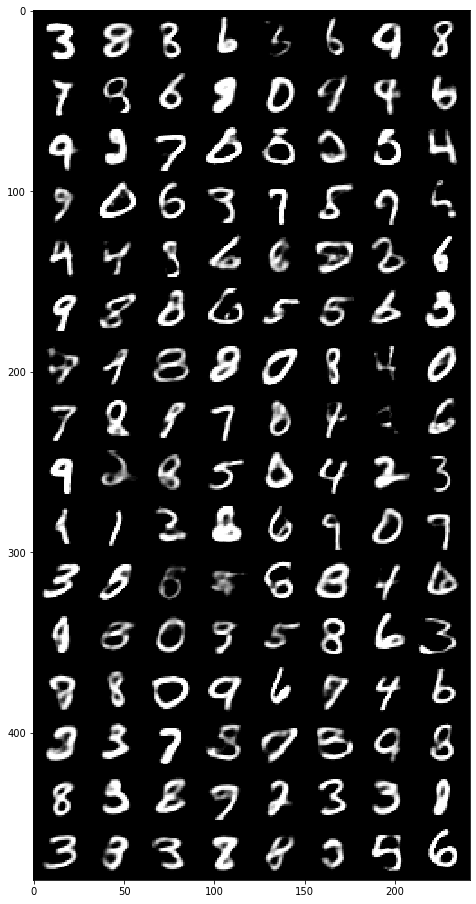

[0.79374601 0.01188815 0.00999482 0.00866948 0.00756338 0.00732422
 0.00703524 0.00686583 0.00658681 0.00646724 0.00656688 0.00713489
 0.00669643 0.0072146  0.00723453 0.00746373 0.00839047 0.00855987
 0.00998485 0.06461256] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


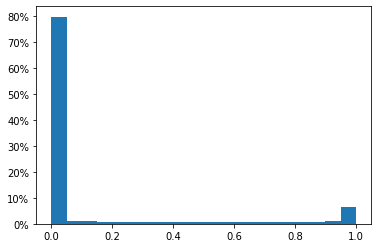

In [ ]:
plt.figure(figsize=(8, 16))

with torch.no_grad():
    z = torch.randn(128, 32).cuda()
    # print (z.shape)
    sample = vae.decoder(z).cuda()
    unnormalized = post_process_vae_output(sample.view(128, 1, 28, 28))
    show(make_grid(unnormalized, normalize=False, scale_each=False))
    plt.show()
    pixel_histogram(unnormalized, num_bins=20)

> Note: The samples above contain samples of varying ambiguity.

Compare to MNIST test samples:

tensor(0.) tensor(1.)


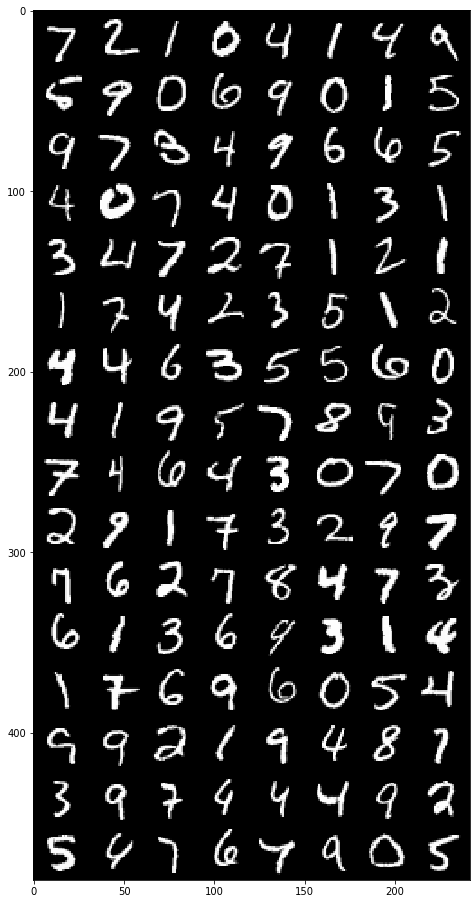

[0.83092514 0.00846022 0.00646724 0.00518176 0.0058793  0.00518176
 0.00520169 0.00443439 0.00427495 0.00443439 0.00578962 0.00445432
 0.00472337 0.00501236 0.00523158 0.0053412  0.00611846 0.00653699
 0.0085798  0.06777144] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


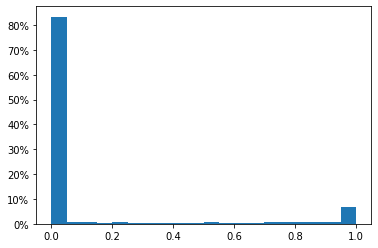

In [ ]:
plt.figure(figsize=(8, 16))
for data, _ in mnist_test_loader:
    unnormalized = unnormalize_mnist(data.view(batch_size, 1, 28, 28))
    print(unnormalized.min(), unnormalized.max())
    show(make_grid(unnormalized, normalize=False, scale_each=False))
    plt.show()
    plt.show()
    pixel_histogram(unnormalized, num_bins=20)
    break

The histograms are already quite similar. A visual test seems to validate this further.

## LeNet Ensemble for Classification

We want samples that are ambiguous but not out-of-distribution. Epistemic uncertainty should be low, but aleatoric uncertainty should be: **someone looking at the sample should recognize that is a digit, but should not be able to tell which one with certainty.**

We can measure epistemic uncertainty using the mutual information of an ensemble. When the mutual information is low, that is epistemic uncertainty is low, the predictive entropy will tell us the aleatoric uncertainty.

A slightly adapted version of LeNet-5 (https://ieeexplore.ieee.org/document/726791). We don't use padding, use max pooling and ReLUs.

In [ ]:
# Train a LeNet on MNIST
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
def lenet_train(epoch, train_loader, optimizer, lenet):
    lenet.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.cuda()
        label = label.cuda()
        optimizer.zero_grad()

        out = lenet(data)
        loss = F.cross_entropy(out, label)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))


def lenet_test(test_loader, lenet):
    lenet.eval()
    test_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.cuda()
            label = label.cuda()
            out = lenet(data)

            # sum up batch loss
            test_loss += F.cross_entropy(out, label).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))
    return test_loss

In [ ]:
lenets = []
num_ensemble_components = 5

for i in tqdm(range(num_ensemble_components)):

    @restore_or_create(f"lenet_model_{i}.model")
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(
            range(1, 101 // num_ensemble_components)
        ):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, mnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    lenets.append(train_lenet_model())

  0%|          | 0/5 [00:00<?, ?it/s]

## Calibrating the VAE

### Reconstructing MNIST's training set
Let's calibrate the output of the VAE to match real MNIST as much as possible. We want to improve over `post_process_vae_output` as much as possible. The simplest solution to this is to pass all MNIST training samples through the VAE and look at the histogram after they have been decoded.

In [ ]:
class_indices = [np.nonzero((mnist_train_dataset.targets == c).cpu().numpy())[0] for c in range(10)]

In [ ]:
def pred_entropy(
    pre_softmaxs,
):  # shape: [MC samples from pred / ensemble, num data, classes]
    softmaxs = F.softmax(pre_softmaxs, dim=-1)
    softmax = torch.mean(softmaxs, dim=0)
    logits = torch.log(softmax)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    return nats.sum(dim=-1)


def avg_entropy(
    pre_softmaxs,
):  # shape: [MC samples from pred / ensemble, num data, classes]
    # NOTE: looking at average ent, not pred ent
    softmax = F.softmax(pre_softmaxs, dim=-1)
    logits = F.log_softmax(pre_softmaxs, dim=-1)
    nats = -logits * softmax
    nats[torch.isnan(nats)] = 0.0
    nats = nats.sum(dim=-1)  # sum over classes
    return nats.mean(dim=0)  # average over MC samples!

In [ ]:
@restore_or_create("decoded_mnist_train.pt", recreate=False)
@torch.no_grad()
def decode_mnist_train_samples():
    decoded_images = []
    decoded_labels = []

    correct_labels = 0
    total_labels = 0

    for data, labels in tqdm(
        zip(
            torch.split(normalize_mnist(mnist_train_dataset.data / 255.0), 1024),
            torch.split(torch.as_tensor(mnist_train_dataset.targets), 1024),
        )
    ):
        batch_mus = vae.encoder(data.cuda().view(-1, 784))[0]
        batch_images = vae.decoder(batch_mus).view(-1, 1, 28, 28)

        normalized_samples = normalize_mnist(post_process_vae_output(batch_images))
        lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_labels = F.softmax(lenet_pre_softmaxs, dim=-1).mean(dim=0).argmax(dim=-1)

        correct_labels += (batch_labels.cpu() == labels).sum().item()
        total_labels += len(labels)

        decoded_images.append(batch_images.cpu())
        decoded_labels.append(batch_labels.cpu())

    decoded_images = torch.cat(decoded_images).cpu()
    decoded_labels = torch.cat(decoded_labels).cpu()

    print(f"Acc: {100*correct_labels/total_labels}")
    return decoded_images, decoded_labels


(
    decoded_mnist_train_images,
    decoded_mnist_train_labels,
) = decode_mnist_train_samples()

[0.81766473 0.00818261 0.00677455 0.00538276 0.00559016 0.00534005
 0.00515952 0.00415232 0.00496624 0.00452874 0.00600338 0.0046942
 0.00468999 0.00529315 0.00565223 0.00537504 0.00601399 0.00699324
 0.00853648 0.07900661] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


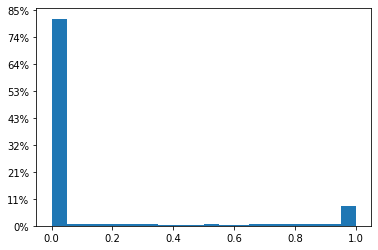

[0.80878151 0.00908006 0.00745744 0.00646762 0.00582778 0.00541203
 0.00514373 0.00494284 0.00484881 0.0048574  0.00488195 0.00502591
 0.00521507 0.0054771  0.00585381 0.00635389 0.00703382 0.00795721
 0.00914539 0.08023663] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


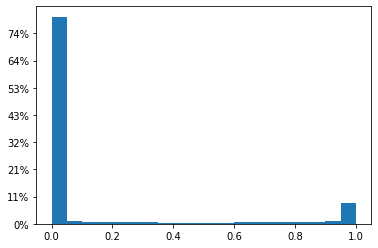

In [ ]:
num_histogram_bins = 20
pixel_histogram(mnist_train_dataset.data / 255.0, num_histogram_bins)
pixel_histogram(post_process_vae_output(decoded_mnist_train_images), num_bins=num_histogram_bins)

We see two peaks: 82% of the pixels are close to 0 and 7.9% are close to 1.

The histograms already look like quite similar. Can we do better though?

We will compute and adjust the unnormalized samples to match the unnormalized MNIST samples as much as possible, which yields `adjusted_post_process_vae_output`. The adjusted histogram mostly matches MNIST better now. This "optimization" was done using graduate student descent while treating the scale and shift in `adjusted_post_process_vae_output` as hyperparameters:

In [ ]:
vae_mnist_mean = torch.mean(decoded_mnist_train_images)
vae_mnist_std = torch.std(decoded_mnist_train_images)
print(vae_mnist_mean, vae_mnist_std)

vae_mnist_min, vae_mnist_max = (
    decoded_mnist_train_images.min(),
    decoded_mnist_train_images.max(),
)
print(vae_mnist_min, vae_mnist_max)

tensor(-5.7765e-06) tensor(0.9357)
tensor(-0.4242) tensor(2.8213)


For comparison, let's verify that our MNIST normalization constants are sensible:

In [ ]:
torch.mean(mnist_train_dataset.data / 255.0), torch.std(mnist_train_dataset.data / 255.0)

(tensor(0.1307), tensor(0.3081))

In [ ]:
mnist_mean, mnist_std

(0.1307, 0.3081)

Anyhow, here is the adjusted post-processing function:

In [ ]:
def adjusted_post_process_vae_output(sample):
    # Instead of using unnormalize_mnist directly, we first normalize the samples using the real mean and std dev.
    normalized_amnist = (sample - vae_mnist_mean) / vae_mnist_std
    unnormalized_mnist = unnormalize_mnist(normalized_amnist)
    unnormalized_mnist = torch.clamp(1.20 * unnormalized_mnist - 0.15, 0, 1)
    return unnormalized_mnist

[0.81321301 0.00445172 0.00454622 0.00363639 0.0034013  0.00337326
 0.00273287 0.00264989 0.0031994  0.00239075 0.00315825 0.0021818
 0.00218325 0.00297628 0.00210927 0.00204305 0.0025611  0.00240514
 0.00245193 0.00207681 0.00344913 0.00255425 0.00242466 0.00226954
 0.00251603 0.00217396 0.00308497 0.00220818 0.0022665  0.00338574
 0.00262659 0.00274845 0.00298314 0.00303085 0.00348125 0.00351199
 0.00394821 0.00458827 0.00460944 0.07439717] [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


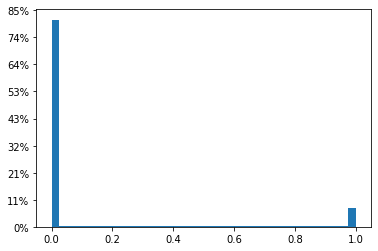

[0.81529634 0.00408503 0.00374069 0.00344713 0.00324371 0.00306027
 0.00290755 0.00280285 0.00269681 0.00262083 0.0025581  0.00252349
 0.00245804 0.00243395 0.00240708 0.00240731 0.0024156  0.00241301
 0.00242353 0.00244477 0.00248323 0.00252823 0.00257993 0.00264058
 0.00269915 0.00278854 0.00288301 0.00299082 0.00311031 0.00326952
 0.00343121 0.00364415 0.00387192 0.00414356 0.00442989 0.00480544
 0.0052432  0.00576556 0.00644454 0.06186112] [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


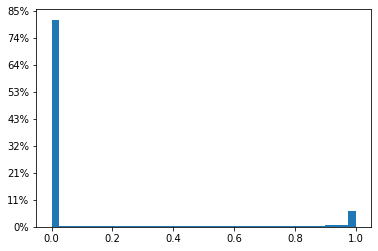

[0.80324728 0.00553423 0.0048037  0.00427636 0.00387283 0.00358461
 0.00332192 0.00314571 0.0029743  0.00285349 0.00275085 0.00266118
 0.00258895 0.00255478 0.00248863 0.00245421 0.00242808 0.00242073
 0.00242838 0.00242902 0.00242343 0.00245852 0.00248718 0.00253873
 0.002573   0.00264207 0.00269779 0.00277932 0.00287253 0.00298127
 0.00310912 0.00324477 0.00341327 0.00362056 0.00384537 0.00411184
 0.00439464 0.00475074 0.00519116 0.07504547] [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


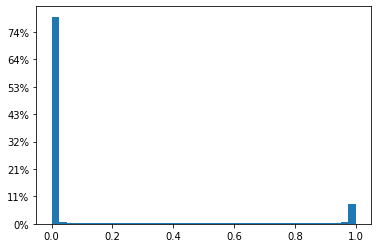

In [ ]:
num_histogram_bins = 20 * 2
pixel_histogram(mnist_train_dataset.data / 255.0, num_histogram_bins)
pixel_histogram(adjusted_post_process_vae_output(decoded_mnist_train_images), num_bins=num_histogram_bins)
pixel_histogram(post_process_vae_output(decoded_mnist_train_images), num_bins=num_histogram_bins)

### Wasserstein Distance

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
def compare_distributions(pixels_a, pixels_b):
    return wasserstein_distance(pixels_a.flatten().numpy(), pixels_b.flatten().numpy())

In [ ]:
print(
    "MNIST vs reconstruction:",
    compare_distributions(mnist_train_dataset.data / 255.0, post_process_vae_output(decoded_mnist_train_images)),
)
print(
    "MNIST vs adjusted reconstruction:",
    compare_distributions(
        mnist_train_dataset.data / 255.0, adjusted_post_process_vae_output(decoded_mnist_train_images)
    ),
)

MNIST vs reconstruction: 0.0058388380341273145
MNIST vs adjusted reconstruction: 0.002503224875531966


`adjusted_post_process_vae_output` improves the histgram more than `post_process_vae_output`, which is what we wanted.

### Visualizing a few samples

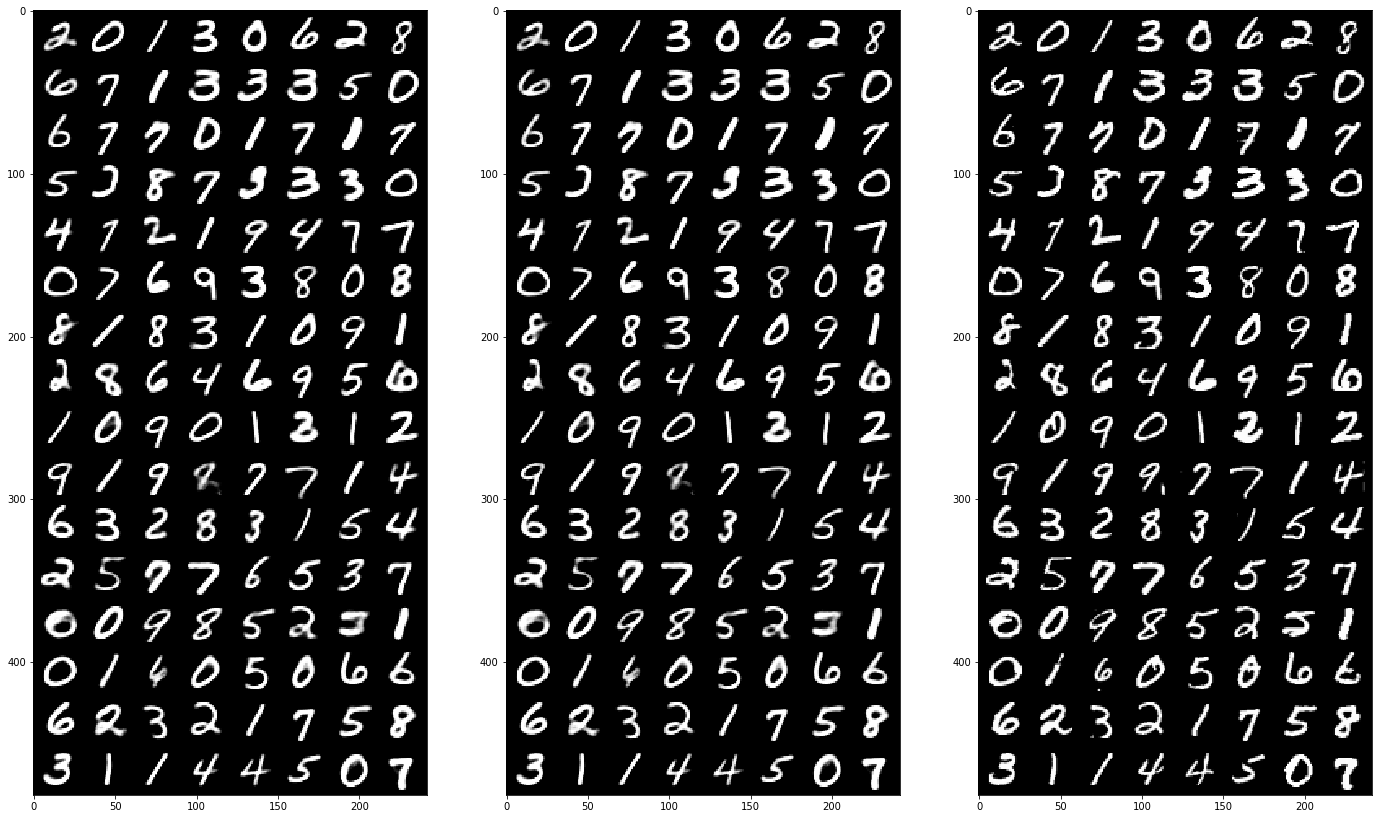

In [ ]:
plt.figure(figsize=(24, 16))
plt.subplot(1, 3, 1)

sample = decoded_mnist_train_images[5 :: len(decoded_mnist_train_images) // 128][:128]
unnormalized = post_process_vae_output(sample.view(128, 1, 28, 28))
show(make_grid(unnormalized, normalize=False, scale_each=False))

plt.subplot(1, 3, 2)
sample = decoded_mnist_train_images[5 :: len(decoded_mnist_train_images) // 128][:128]
unnormalized = adjusted_post_process_vae_output(sample.view(128, 1, 28, 28))
show(make_grid(unnormalized, normalize=False, scale_each=False))

plt.subplot(1, 3, 3)
sample = mnist_train_dataset.data[5 :: len(mnist_train_dataset.data) // 128][:128] / 255.0
unnormalized = sample.view(128, 1, 28, 28)
show(make_grid(unnormalized, normalize=False, scale_each=False))
plt.show()

## Creating Ambiguous VAE Samples

We try to different methods: 
a) we sample from the latent space. Because we have a VAE, the latents are optimized to conform to a Gaussian distribution.
b) we sample from convex combinations of latents from real MNIST training samples.

### Sampling from the Latent Space

In [ ]:
@restore_or_create("stratified_ambiguous_samples.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_samples():
    mi_threshold = 0.05
    bin_edges = [0, 0.05, 0.5, 1.0, 10.0]
    target_counts = [60000, 30000, 20000, 10000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    batch_size = 16384

    total_target_count = sum(target_counts)

    sample_progress = tqdm(range(total_target_count))
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        z = torch.randn(batch_size, 32).cuda()
        decoded_lerps = vae.decoder(z).view(batch_size, 1, 28, 28)

        normalized_samples = normalize_mnist(adjusted_post_process_vae_output(decoded_lerps))
        lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
        batch_mi = batch_pred_entropies - batch_avg_entropies

        id_samples = batch_mi <= mi_threshold

        for bucket_index, (count, target, bucket, lower, upper) in enumerate(
            zip(
                bucket_counts,
                target_counts,
                buckets,
                bin_edges[:-1],
                bin_edges[1:],
            )
        ):
            bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
            num_new_samples = bucket_samples.sum().item()

            if num_new_samples == 0 or count >= target:
                continue

            bucket.append(decoded_lerps[bucket_samples])
            bucket_counts[bucket_index] += num_new_samples
            sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets)
    return buckets


stratified_ambiguous_samples_random_latent = create_stratified_ambiguous_samples().cpu()

### Sampling Convex Combinations of MNIST Training Samples

In [ ]:
@restore_or_create("stratified_ambiguous_samples_convex_mixture.pt", recreate=False)
@torch.no_grad()
def create_stratified_ambiguous_mixture_samples():
    mi_threshold = 0.05
    bin_edges = [0, 0.05, 0.5, 1.0, 1.6]
    target_counts = [60000, 60000, 40000, 20000]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    total_target_count = sum(target_counts)

    num_samples_per_clique = 64

    num_label_range = list(range(2, 5))

    batch_size = 65536 // num_samples_per_clique

    sample_progress = tqdm(total=total_target_count)
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        sample_progress.total = sum(max(count, target) for count, target in zip(bucket_counts, target_counts))

        for num_labels in num_label_range:
            num_new_samples = 0

            batch_labels = []
            batch_data = []
            for j in range(batch_size):
                label = np.random.choice(10, num_labels, replace=False)
                batch_indices = [np.random.choice(len(class_indices[c]), 1)[0] for c in label]
                data = torch.stack([mnist_train_dataset[i][0] for i in batch_indices]).cuda()
                label = torch.tensor(label).cuda()
                batch_labels.append(label)
                batch_data.append(data)

            batch_data = torch.stack(batch_data)
            batch_labels = torch.stack(batch_labels)

            mu, logvar = vae.encoder(batch_data.view(-1, 784))

            mix_weights = torch.rand(batch_size * num_samples_per_clique, num_labels + 1).cuda()
            mix_weights[:, 0] = 0
            mix_weights[:, -1] = 1
            mix_weights = torch.sort(mix_weights, dim=-1)[0]
            mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
            mixed_encodings = mix_weights.view(batch_size, num_samples_per_clique, num_labels) @ mu.view(
                batch_size, num_labels, -1
            )
            decoded_lerps = vae.decoder(mixed_encodings).view(batch_size * num_samples_per_clique, 1, 28, 28)

            normalized_samples = normalize_mnist(adjusted_post_process_vae_output(decoded_lerps))
            lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
            lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
            batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
            batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
            batch_mi = batch_pred_entropies - batch_avg_entropies

            id_samples = batch_mi <= mi_threshold

            for bucket_index, (count, target, bucket, lower, upper,) in enumerate(
                zip(
                    bucket_counts,
                    target_counts,
                    buckets,
                    bin_edges[:-1],
                    bin_edges[1:],
                )
            ):
                bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
                num_new_samples = bucket_samples.sum().item()

                if num_new_samples == 0 or count >= target:
                    continue

                bucket.append(decoded_lerps[bucket_samples].cpu())
                bucket_counts[bucket_index] += num_new_samples
                sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets).cpu()
    return buckets


stratified_ambiguous_samples_convex_mixture = create_stratified_ambiguous_mixture_samples().cpu()

In [ ]:
@restore_or_create("ambiguous_samples_convex_mixture.pt", recreate=True)
@torch.no_grad()
def create_ambiguous_mixture_samples():
    mi_threshold = 0.05
    bin_edges = [0.05, 3]
    target_counts = [2 ** 20]
    num_bins = len(bin_edges) - 1
    bucket_counts = [0] * num_bins
    buckets = [[] for _ in range(num_bins)]

    assert len(target_counts) == len(bucket_counts) == len(buckets) == num_bins

    total_target_count = sum(target_counts)

    num_samples_per_clique = 64

    num_label_range = list(range(2, 5))

    batch_size = 65536 // num_samples_per_clique

    label_batch_size = 32

    sample_progress = tqdm(total=total_target_count)
    while any(count < target for count, target in zip(bucket_counts, target_counts)):
        sample_progress.total = sum(max(count, target) for count, target in zip(bucket_counts, target_counts))

        for num_labels in num_label_range:
            num_new_samples = 0

            batch_labels = []
            batch_data = []
            for j in range(batch_size // label_batch_size):
                label = np.random.choice(10, num_labels, replace=False)
                batch_indices = [np.random.choice(len(class_indices[c]), label_batch_size) for c in label]
                data = torch.stack(
                    [normalize_mnist(mnist_train_dataset.data[i] / 255.0) for i in batch_indices], dim=1
                ).cuda()
                label = torch.tensor(np.repeat(label, label_batch_size)).cuda()
                batch_labels.append(label)
                batch_data.append(data)

            batch_data = torch.stack(batch_data)
            batch_labels = torch.stack(batch_labels)

            mu, logvar = vae.encoder(batch_data.view(-1, 784))

            mix_weights = torch.rand(batch_size * num_samples_per_clique, num_labels + 1).cuda()
            mix_weights[:, 0] = 0
            mix_weights[:, -1] = 1
            mix_weights = torch.sort(mix_weights, dim=-1)[0]
            mix_weights = mix_weights[:, 1:] - mix_weights[:, :-1]
            mixed_encodings = mix_weights.view(batch_size, num_samples_per_clique, num_labels) @ mu.view(
                batch_size, num_labels, -1
            )
            decoded_lerps = vae.decoder(mixed_encodings).view(batch_size * num_samples_per_clique, 1, 28, 28)

            normalized_samples = normalize_mnist(adjusted_post_process_vae_output(decoded_lerps))
            lenet_pre_softmaxs = [lenet(normalized_samples.cuda()) for lenet in lenets]
            lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)
            batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
            batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)
            batch_mi = batch_pred_entropies - batch_avg_entropies

            id_samples = batch_mi <= mi_threshold

            for bucket_index, (count, target, bucket, lower, upper,) in enumerate(
                zip(
                    bucket_counts,
                    target_counts,
                    buckets,
                    bin_edges[:-1],
                    bin_edges[1:],
                )
            ):
                bucket_samples = id_samples & (lower <= batch_pred_entropies) & (batch_pred_entropies < upper)
                num_new_samples = bucket_samples.sum().item()

                if num_new_samples == 0 or count >= target:
                    continue

                bucket.append(decoded_lerps[bucket_samples].cpu())
                bucket_counts[bucket_index] += num_new_samples
                sample_progress.update(num_new_samples)

    sample_progress.close()

    buckets = [torch.cat(bucket).cpu() for bucket in buckets if bucket]
    buckets = torch.cat(buckets).cpu()
    return buckets


ambiguous_samples_convex_mixture = create_ambiguous_mixture_samples().cpu()

  0%|          | 0/1048576 [00:00<?, ?it/s]

### Comparison of the different sampling methods

We compute various statistics to examine the samples we have generated further.

In [ ]:
from dataclasses import dataclass


@dataclass
class SampleEvaluation:
    pred_entropies: torch.Tensor
    mutual_infos: torch.Tensor
    softmax_logits: torch.Tensor
    softmax_predictions: torch.Tensor
    predictions: torch.Tensor
    single_labels: torch.Tensor

In [ ]:
@torch.no_grad()
def evaluate_samples(samples):
    pred_entropies = []
    avg_entropies = []
    softmax_logits = []
    softmax_predictions = []
    predictions = []
    predicted_labels = []

    for decoded_image_batch in tqdm(torch.split(samples, 32768)):
        normalized_sample = normalize_mnist(adjusted_post_process_vae_output(decoded_image_batch.cuda()))
        lenet_pre_softmaxs = [lenet(normalized_sample) for lenet in lenets]
        lenet_pre_softmaxs = torch.stack(lenet_pre_softmaxs)

        batch_pred_entropies = pred_entropy(lenet_pre_softmaxs)
        batch_avg_entropies = avg_entropy(lenet_pre_softmaxs)

        pred_entropies.append(batch_pred_entropies.cpu())
        avg_entropies.append(batch_avg_entropies.cpu())

        lenet_pre_softmaxs = torch.transpose(lenet_pre_softmaxs, 0, 1)  # swap MC samples with batch dims
        softmax_logits.append(lenet_pre_softmaxs.cpu())

        batch_sm_pred = F.softmax(lenet_pre_softmaxs, dim=-1)
        softmax_predictions.append(batch_sm_pred.cpu())

        batch_pred = batch_sm_pred.mean(dim=1)
        predictions.append(batch_pred.cpu())

        batch_pred_labels = batch_pred.argmax(-1)
        predicted_labels.append(batch_pred_labels.cpu())

    pred_entropies = torch.cat(pred_entropies)
    avg_entropies = torch.cat(avg_entropies)
    softmax_logits = torch.cat(softmax_logits)
    softmax_predictions = torch.cat(softmax_predictions)
    predictions = torch.cat(predictions)
    predicted_labels = torch.cat(predicted_labels)

    return SampleEvaluation(
        pred_entropies,
        pred_entropies - avg_entropies,
        softmax_logits,
        softmax_predictions,
        predictions,
        predicted_labels,
    )


stratified_ambiguous_samples_random_latent_evaluation = restore_or_create(
    "stratified_ambiguous_samples_random_latent_evaluation.pt", recreate=False
)(lambda: evaluate_samples(stratified_ambiguous_samples_random_latent))()

stratified_ambiguous_samples_convex_mixture_evaluation = restore_or_create(
    "stratified_ambiguous_samples_convex_mixture_evaluation.pt", recreate=False
)(lambda: evaluate_samples(stratified_ambiguous_samples_convex_mixture))()

ambiguous_samples_convex_mixture_evaluation = restore_or_create(
    "ambiguous_samples_convex_mixture_evaluation.pt", recreate=True
)(lambda: evaluate_samples(ambiguous_samples_convex_mixture))()

  0%|          | 0/33 [00:00<?, ?it/s]

### Predictive Entropy Histogram

(Note we remove samples with MI > 0.1)

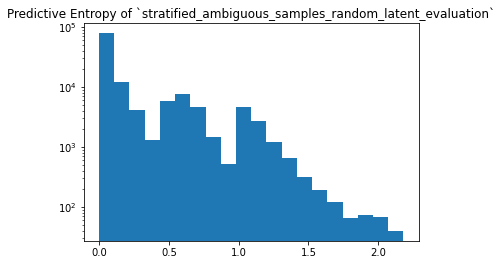

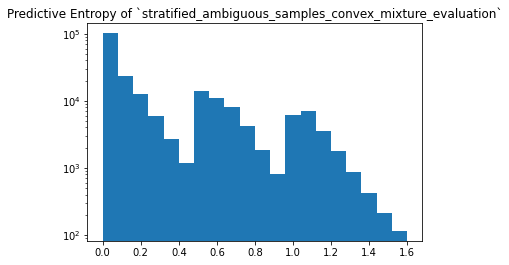

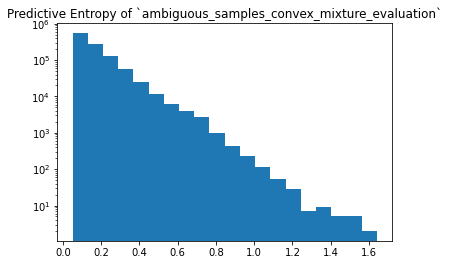

In [ ]:
plt.yscale("log")
plt.hist(stratified_ambiguous_samples_random_latent_evaluation.pred_entropies.numpy(), bins=20)
plt.title("Predictive Entropy of `stratified_ambiguous_samples_random_latent_evaluation`")
plt.show()

plt.yscale("log")
plt.hist(stratified_ambiguous_samples_convex_mixture_evaluation.pred_entropies.numpy(), bins=20)
plt.title("Predictive Entropy of `stratified_ambiguous_samples_convex_mixture_evaluation`")
plt.show()

plt.yscale("log")
plt.hist(ambiguous_samples_convex_mixture_evaluation.pred_entropies.numpy(), bins=20)
plt.title("Predictive Entropy of `ambiguous_samples_convex_mixture_evaluation`")
plt.show()

#### Example Samples

[[7], [4], [7], [1]]
[[5], [7], [2], [3]]
[[7], [1], [1], [7]]
[[5], [7], [9], [3]]
[[2], [9], [2], [8]]
[[9], [6], [7], [5]]
[[7], [1], [5], [3]]
[[5], [1, 7], [2, 0], [6]]
[[1], [5], [7], [5, 3]]
[[9, 4], [2, 7], [8, 3], [1, 8]]
[[3, 5], [1, 7], [1, 7], [9, 5]]
[[1, 8], [7, 1], [9, 7], [7, 3]]
[[9, 3], [6, 0], [9, 3], [7, 1]]
[[5, 9], [5, 9], [1, 7], [5, 7]]
[[1, 7], [3, 5], [5, 3], [5, 3]]


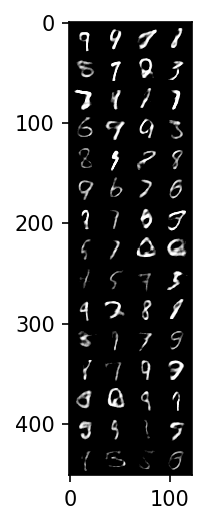

[[2], [4], [9], [8]]
[[5], [2], [6], [7]]
[[8], [2], [8], [2]]
[[8], [3], [3], [3]]
[[4], [2], [1], [2]]
[[2], [0], [1], [3]]
[[7], [0], [1], [0]]
[[8], [9, 3], [9, 8], [3]]
[[9, 8], [9], [8], [1]]
[[1, 7], [6, 8], [2, 7], [4, 9]]
[[2, 3], [1, 7], [0, 2], [6, 0]]
[[7, 9], [6, 8], [8, 1], [9, 4]]
[[1, 7], [9, 8], [1, 9], [5, 8]]
[[3, 8], [1, 9], [1, 8], [8, 9]]
[[8, 9], [9, 8, 3], [8, 6], [7, 1]]


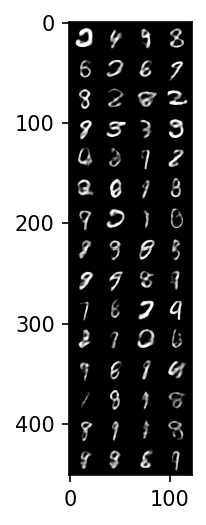

[[0], [3], [3], [6]]
[[9], [6], [9], [1]]
[[7], [3], [4], [8]]
[[9], [2], [2], [3]]
[[2], [9], [7], [9]]
[[2], [8], [7], [1]]
[[6], [0, 2], [6, 5], [3]]
[[7], [9], [2], [4]]
[[4, 9], [1], [3, 8], [1, 7]]
[[9, 4], [9, 7], [7, 1], [5, 8]]
[[3, 5], [7, 9], [1, 7], [8, 2]]
[[7, 1], [5, 9], [8, 3], [9, 8]]
[[5, 3], [8, 1], [1, 2], [7, 9]]
[[9, 7], [3, 9], [9, 7], [7, 9]]
[[7, 9], [9, 8], [1, 7], [8, 9]]


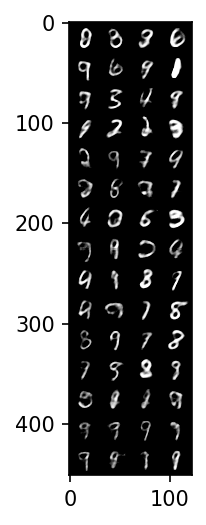

In [ ]:
def show_stratified_samples(
    samples, pred_entropies, num_pe_bins, num_bin_samples, bin_range=None, predictions=None, one_per_class=False
):
    stratified_samples = []
    edges = np.histogram_bin_edges(pred_entropies, bins=num_pe_bins, range=bin_range)
    for lower, upper in zip(edges[:-1], edges[1:]):
        bucket_mask = (pred_entropies >= lower) & (pred_entropies < upper)
        bucket_samples = samples[bucket_mask]
        if one_per_class:
            assert num_bin_samples == 10
            assert predictions is not None
            bucket_predictions = predictions[bucket_mask]
            bucket_labels = predictions[bucket_mask].argmax(dim=-1)
            sample_indices = np.concatenate(
                [np.random.choice(torch.nonzero(bucket_labels == c, as_tuple=False)[:, 0], size=1) for c in range(10)]
            )
        else:
            sample_indices = np.random.choice(len(bucket_samples), size=num_bin_samples, replace=False)
        row_samples = bucket_samples[sample_indices]
        stratified_samples.append(row_samples)
        if predictions is not None:
            sorted_probs, original_indices = torch.sort(
                predictions[bucket_mask][sample_indices], dim=-1, descending=True
            )
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            row_labels = []
            for sample_classes, cumulative_prob in zip(original_indices, cumulative_probs):
                majority_labels = []
                for c, cs in zip(sample_classes, cumulative_prob):
                    majority_labels += [c.item()]
                    if cs > 0.8:
                        break
                row_labels += [majority_labels]
            print(row_labels)

    stratified_samples = torch.cat(stratified_samples)
    plt.figure(figsize=(num_pe_bins, num_bin_samples), dpi=150)
    show(
        make_grid(
            adjusted_post_process_vae_output(stratified_samples.view(-1, 1, 28, 28)),
            normalize=False,
            nrow=num_bin_samples,
        )
    )
    plt.show()


show_stratified_samples(
    stratified_ambiguous_samples_random_latent,
    stratified_ambiguous_samples_random_latent_evaluation.pred_entropies,
    15,
    4,
    bin_range=[0.05, 1.1],
    predictions=stratified_ambiguous_samples_random_latent_evaluation.predictions,
)
show_stratified_samples(
    stratified_ambiguous_samples_convex_mixture,
    stratified_ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    15,
    4,
    bin_range=[0.05, 1.1],
    predictions=stratified_ambiguous_samples_convex_mixture_evaluation.predictions,
)
show_stratified_samples(
    ambiguous_samples_convex_mixture,
    ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    15,
    4,
    bin_range=[0.05, 1.1],
    predictions=ambiguous_samples_convex_mixture_evaluation.predictions,
)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3, 5], [4], [5], [6], [7], [8, 2], [9]]
[[0], [1], [2], [3, 5], [4, 9], [5], [6], [7], [8], [9, 4]]
[[0], [1], [2, 8], [3, 5], [4], [5, 6], [6, 8], [7], [8, 3], [9, 8]]
[[0, 6], [1, 8], [2, 8], [3], [4, 6], [5, 3], [6, 5], [7, 1], [8, 3], [9]]
[[0, 6], [1], [2, 0], [3, 9], [4, 6], [5, 8], [6, 8], [7, 1], [8, 9], [9, 3]]
[[0, 2], [1, 7], [2, 3], [3, 2], [4, 9], [5, 9], [6, 8], [7, 3], [8, 9], [9, 3]]
[[0, 5], [1, 7], [2, 8], [3, 2], [4, 9], [5, 9], [6, 2], [7, 9], [8, 9], [9, 8]]
[[0, 2], [1, 7], [2, 8], [3, 9], [4, 6], [5, 8], [6, 8], [7, 1], [8, 5], [9, 7]]


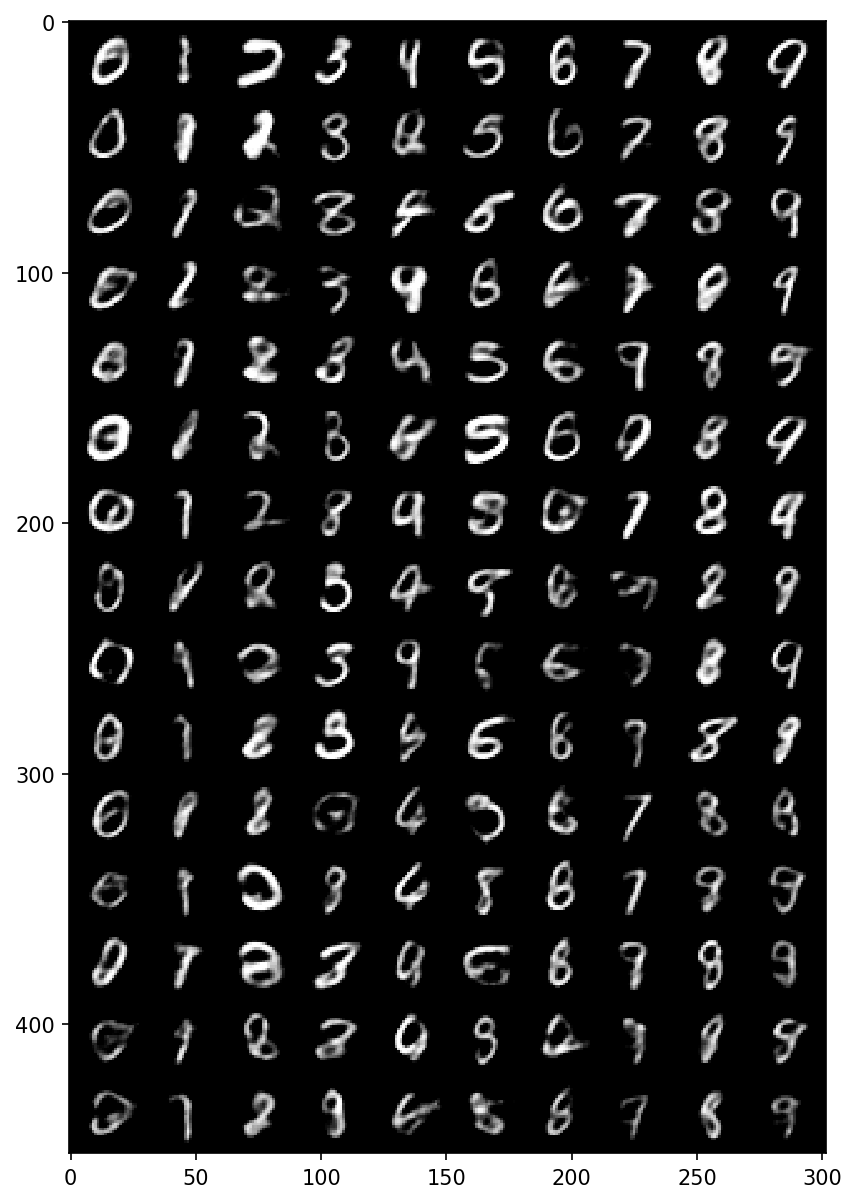

In [ ]:
show_stratified_samples(
    ambiguous_samples_convex_mixture,
    ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    15,
    10,
    bin_range=[0.05, 1],
    predictions=ambiguous_samples_convex_mixture_evaluation.predictions,
    one_per_class=True,
)

The convex mixture samples look much better overall. However, we have to limit the entropy range to `[0.1, 1.4]` as there are not sufficiently many samples beyond that:

(array([0., 1., 0., 3., 1., 0., 0., 0., 0., 0.]),
 array([1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58, 1.6 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

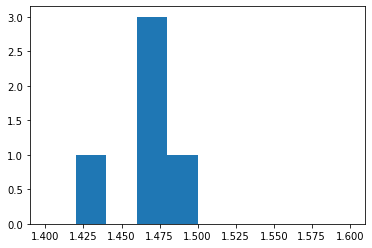

In [ ]:
plt.hist(
    ambiguous_samples_convex_mixture_evaluation.pred_entropies.numpy(),
    bins=10,
    range=[1.4, 1.6],
)

#### Label vs Entropy Distribution

We can look at the distribution of the labels (the most likely label). We see that the created samples are highly imbalanced.

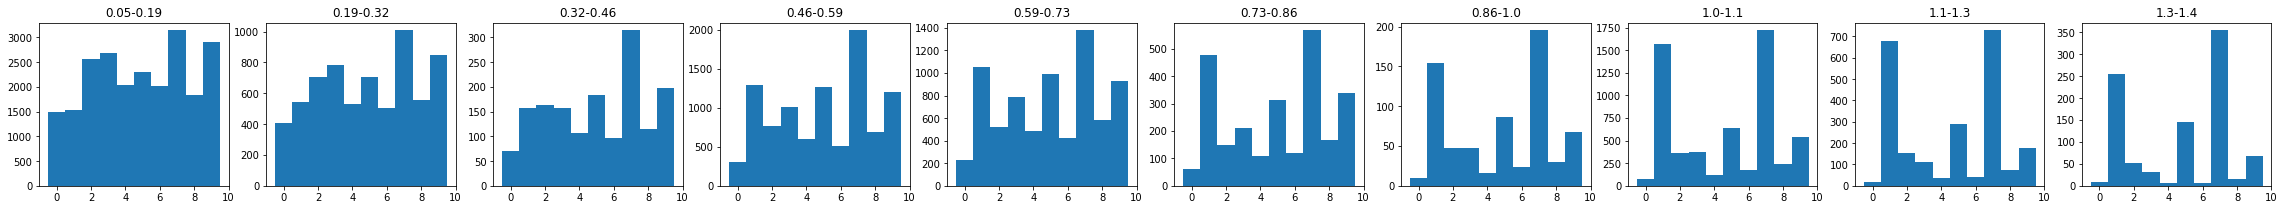

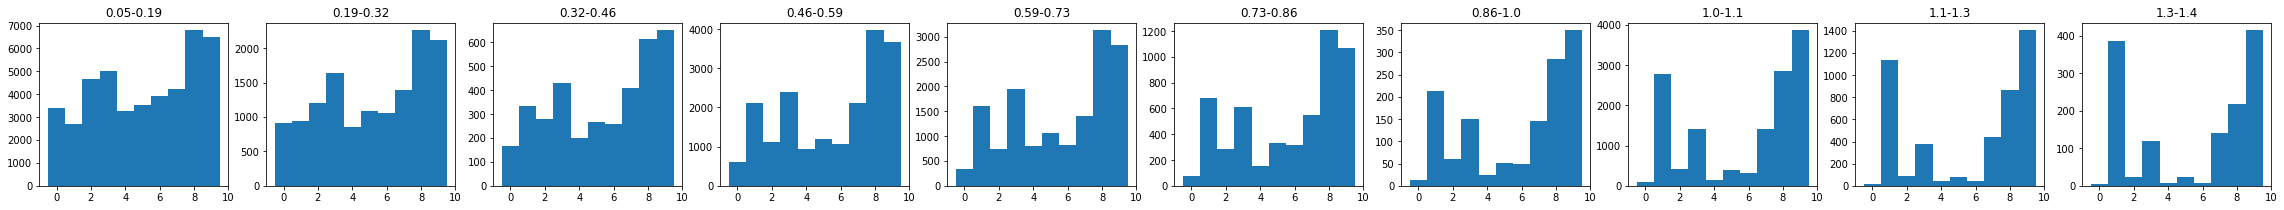

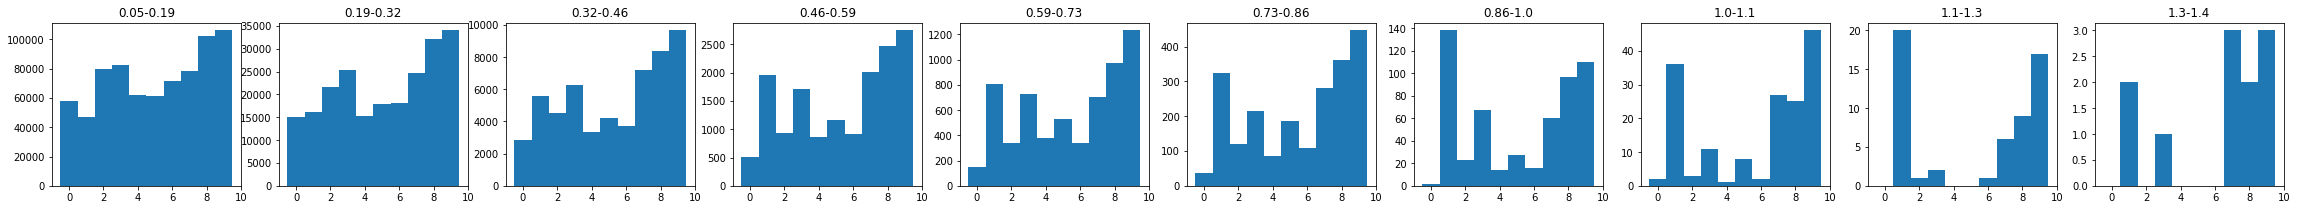

In [ ]:
def show_label_buckets(entropies, labels, num_bins, range=None):
    edges = np.histogram_bin_edges(entropies.numpy(), bins=num_bins, range=range)

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_labels = labels[(lower <= entropies) & (entropies < upper)]
        # plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.hist(bucket_labels.numpy(), bins=10, range=[-0.5, 9.5])

    plt.show()


show_label_buckets(
    stratified_ambiguous_samples_random_latent_evaluation.pred_entropies,
    stratified_ambiguous_samples_random_latent_evaluation.single_labels,
    10,
    range=[0.05, 1.4],
)
show_label_buckets(
    stratified_ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    stratified_ambiguous_samples_convex_mixture_evaluation.single_labels,
    10,
    range=[0.05, 1.4],
)
show_label_buckets(
    ambiguous_samples_convex_mixture_evaluation.pred_entropies,
    ambiguous_samples_convex_mixture_evaluation.single_labels,
    10,
    range=[0.05, 1.4],
)

### Class Probability vs Entropy
We can also look at the distribution of class probability vs entropy:

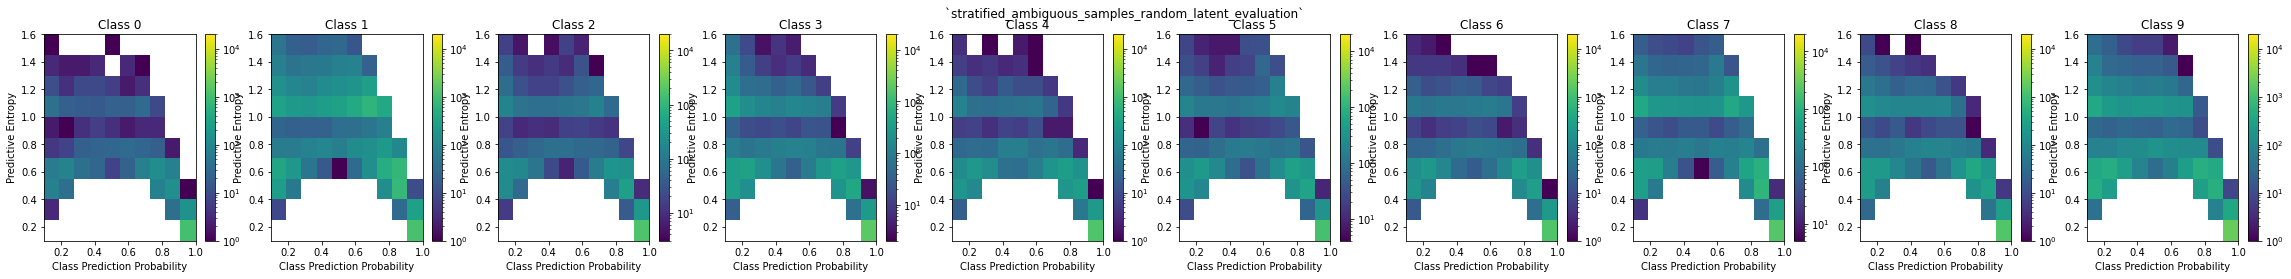

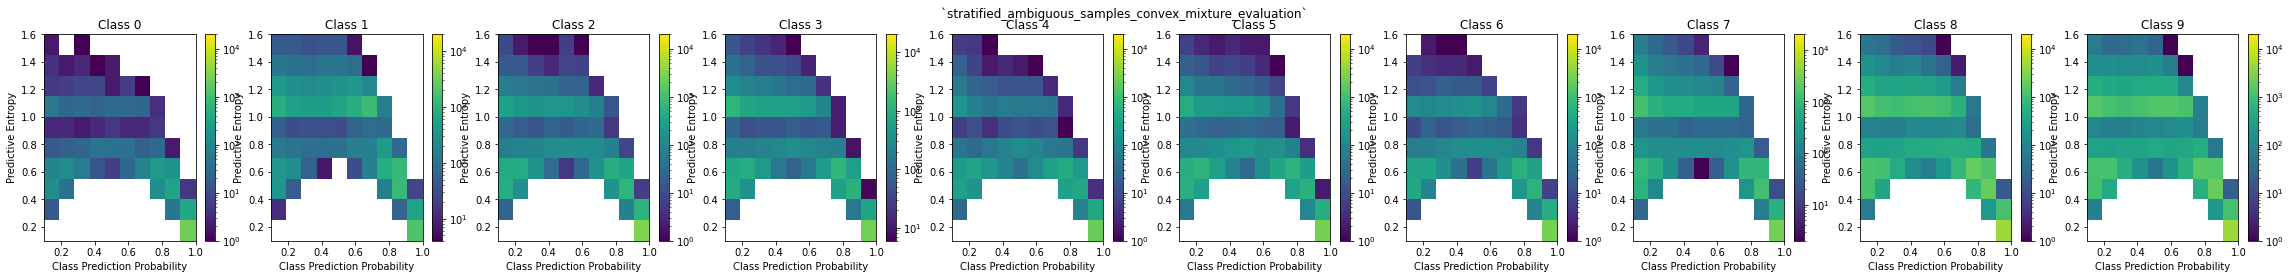

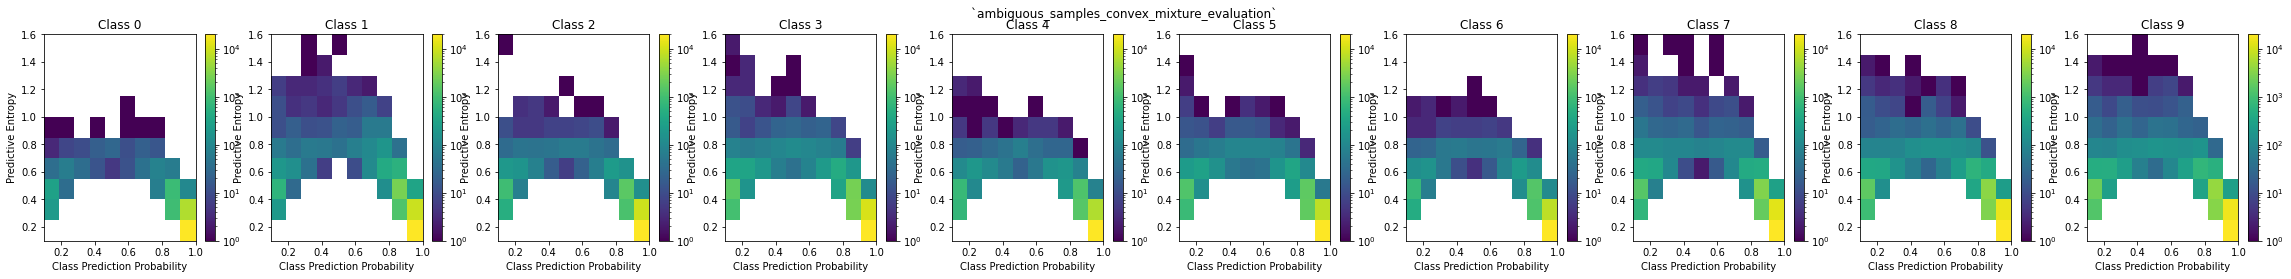

In [ ]:
import matplotlib as mpl


def show_probs_vs_entropy(evaluation: SampleEvaluation, num_bins, entropy_range=None):
    entropies = evaluation.pred_entropies
    predictions = evaluation.predictions

    plt.figure(figsize=(num_bins * 4, 3.8))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        h = plt.hist2d(
            predictions[:, i].numpy(),
            entropies.numpy(),
            bins=num_bins,
            norm=mpl.colors.LogNorm(vmax=2e4),
            range=[[0.1, 1], entropy_range],
        )
        plt.xlabel("Class Prediction Probability")
        plt.ylabel("Predictive Entropy")
        plt.title(f"Class {i}")
        ax = plt.gca()
        plt.colorbar(h[-1], use_gridspec=True, ax=ax)


show_probs_vs_entropy(stratified_ambiguous_samples_random_latent_evaluation, 10, entropy_range=[0.1, 1.6])
plt.suptitle("`stratified_ambiguous_samples_random_latent_evaluation`")
show_probs_vs_entropy(stratified_ambiguous_samples_convex_mixture_evaluation, 10, entropy_range=[0.1, 1.6])
plt.suptitle("`stratified_ambiguous_samples_convex_mixture_evaluation`")
show_probs_vs_entropy(ambiguous_samples_convex_mixture_evaluation, 10, entropy_range=[0.1, 1.6])
plt.suptitle("`ambiguous_samples_convex_mixture_evaluation`")
plt.show()

In [ ]:
# ambiguous_samples = stratified_ambiguous_samples_convex_mixture
# ambiguous_samples_evaluation = stratified_ambiguous_samples_convex_mixture_evaluation

ambiguous_samples = ambiguous_samples_convex_mixture
ambiguous_samples_evaluation = ambiguous_samples_convex_mixture_evaluation

## Balancing the Stratified Samples: Creating Ambiguous-MNIST

Ideally, we want samples that are balanced between classes.

What does that mean for ambiguous samples though?

We define a subset of samples to be balanced when the overal probability mass assinged to all classes is uniform. I.e. $\frac{1}{N} \sum_i p(y=c|x_i) \approx \frac{1}{C}$, where $N$ is the number of samples, and $C$ is the number of classes.

To balance the stratified samples, we want to balance the samples within different ranges of aleatoric uncertianty/entropy.

We examine two approaches to achieve this. The first is fully stochastic and samples random subsets, selecting the one with the highest entropy (being closest to uniform).
The second approach samples stochastically but aiming towards creating a uniform class distribution, while slowly annealing a temperature parameter.

We use the second approach.

To collect, 80k samples, we need 16k samples that we can then draw multiple labels from if we draw 5 labels per sample. This means about 1600 samples per bucket, assuming 10 buckets.

In [ ]:
def entropy(p):
    nats = -p * torch.log(p)
    nats[torch.isnan(nats)] = 0.0
    entropy = torch.sum(nats, dim=-1)
    return entropy

In [ ]:
def kl(p, q):
    items = -p * (torch.log(q) - torch.log(p))
    items[torch.isnan(items)] = 0.0
    kl = torch.sum(items, dim=-1)
    return kl

In [ ]:
def show_prob_buckets(entropies, predictions, num_bins, entropy_range=None):
    edges = np.histogram_bin_edges(entropies.numpy(), bins=num_bins, range=entropy_range)

    plt.figure(figsize=(num_bins * 4, 3))
    for i, (lower, upper) in enumerate(zip(edges[:-1], edges[1:])):
        plt.subplot(1, num_bins, i + 1)
        bucket_prob_distribution = predictions[(lower <= entropies) & (entropies < upper)].mean(dim=0)
        print(entropy(bucket_prob_distribution))
        # plt.yscale("log")
        plt.title(f"{lower:.2}-{upper:.2}")
        plt.ylim(0, 0.3)
        plt.bar(range(10), bucket_prob_distribution.numpy(), width=1)

    plt.show()

### Fully Stochastic Balancing

In [ ]:
@restore_or_create("fully_stochastic_balanced_indices", recreate=False)
def fully_stochastic_balancing():
    max_samples = int(80e3)

    entropies = ambiguous_samples_evaluation.pred_entropies
    predictions = ambiguous_samples_evaluation.predictions

    num_bins = 5
    num_labels = 10
    edges = np.histogram_bin_edges([], bins=num_bins, range=[0.05, 1.5])

    num_stochastic_batches = 1024

    balanced_indices = []

    for lower, upper in tqdm(reversed(list(zip(edges[:-1], edges[1:]))), total=num_bins):
        num_bucket_samples = max_samples // num_bins // num_labels
        prob_masses = torch.zeros(10)

        bucket_mask = (lower <= entropies) & (entropies < upper)
        bucket_indices = torch.nonzero(bucket_mask, as_tuple=False)[:, 0]

        bucket_stochastic_batches = num_stochastic_batches * 181243 // len(bucket_indices)

        # plt.hist(entropies[bucket_indices].numpy(), bins=10, range=[0.1, 1.6])

        print(f"Sampling {num_bucket_samples} out of {len(bucket_indices)}")

        bucket_predictions = predictions[bucket_indices]
        bucket_avg_distribution = bucket_predictions.mean(dim=0)

        bucket_mean_dist = (bucket_predictions + bucket_avg_distribution[None, :]) / 2

        bucket_weights = torch.exp(kl(bucket_predictions, bucket_avg_distribution))

        batch_indices = torch.cat(
            [
                torch.as_tensor(
                    torch.multinomial(
                        bucket_weights.expand(32, len(bucket_indices)),
                        num_samples=num_bucket_samples,
                        replacement=False,
                    )
                )
                for _ in tqdm(range(bucket_stochastic_batches // 32))
            ]
        )
        # batch_indices = torch.multinomial(torch.ones((1, 1)).expand(num_stochastic_batches, len(bucket_indices)), num_samples=num_bucket_samples, replacement=False)

        bucket_stochastic_batches = batch_indices.shape[0]

        batch_indices_BNC = batch_indices.unsqueeze(2).expand((bucket_stochastic_batches, num_bucket_samples, 10))
        predictions_BNC = bucket_predictions.unsqueeze(0).expand((bucket_stochastic_batches, -1, 10))

        batch_prob_mass = torch.gather(predictions_BNC, index=batch_indices_BNC, dim=1).mean(dim=1)
        batch_entropy = entropy(batch_prob_mass)

        plt.title(lower)
        plt.hist(batch_entropy.numpy(), bins=10)
        plt.show()

        best_batch_entropy, best_batch = batch_entropy.max(dim=0)
        best_batch_indices = batch_indices[best_batch]

        print(best_batch_entropy)

        balanced_indices.append(bucket_indices[best_batch_indices])

    balanced_indices = torch.cat(balanced_indices)
    print(len(balanced_indices))
    return balanced_indices


fully_stochastic_balanced_indices = fully_stochastic_balancing()

tensor(2.2692)
tensor(2.2378)
tensor(2.1674)
tensor(2.1106)
tensor(2.1431)
tensor(1.9951)
tensor(1.0430)
tensor(1.6445)
tensor(0.)
tensor(0.)


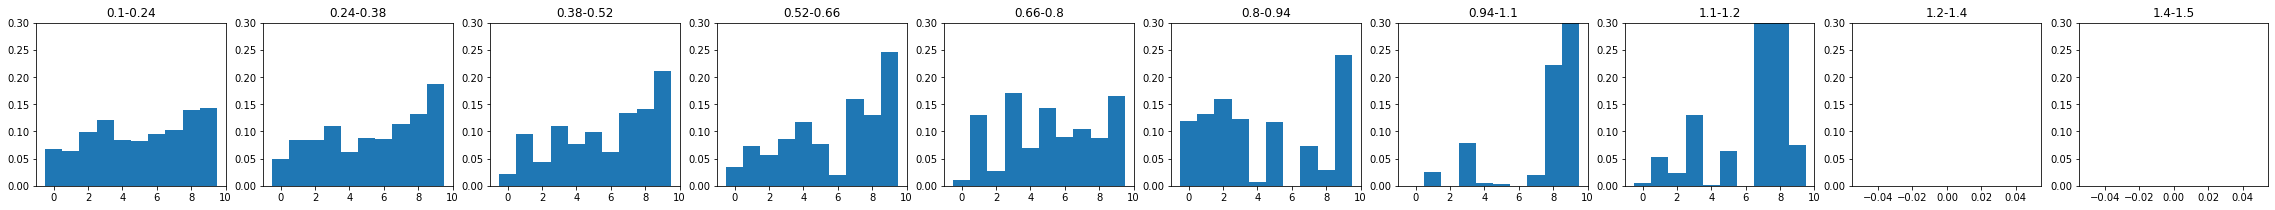

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation.pred_entropies[fully_stochastic_balanced_indices],
    ambiguous_samples_evaluation.predictions[fully_stochastic_balanced_indices],
    10,
    entropy_range=[0.1, 1.5],
)

This does not look for higher entropy buckets.

### Annealing Stochastic Balancing

We start with an empty set in each bucket.

We pick a sample depending on how much it helps us achieve a uniform distribution.

The KL between the bucket's overal probability distribution and a uniform distribution measures how close it is to a uniform distribution:
$$ D_{KL}(p||U) = H(p||U) - H(p) = H(U) - H(p).$$
where $p$ is the distribution after adding the distribution of the sample under consideration:

$$p_\text{new}(p') = \frac{N p_\text{current} + p'}{N+1}$$

We can draw samples from $p' \sim \exp (-D_{KL}(p_\text{new}(p')||U)/\tau)$. Both together:

\begin{align}
D_{KL}(p_\text{total}(p')||U) &= H(U) - H(p_\text{new}(p'))
\end{align}

We anneal $\tau \to 0$ during training to pick the optimal samples later on.

In [ ]:
@restore_or_create("doubly_stratified_indices.pt", recreate=False)
def bucket_stratify_indices():
    max_samples = int(80e3)

    entropies = ambiguous_samples_evaluation.pred_entropies
    predictions = ambiguous_samples_evaluation.predictions

    num_bins = 5
    num_labels = 10

    stratified_indices = []

    gammas = [1, 1, 1.2, 2, 2]

    edges = np.histogram_bin_edges([], bins=num_bins, range=[0.05, 1.45])
    for lower, upper, gamma in tqdm(reversed(list(zip(edges[:-1], edges[1:], gammas))), total=num_bins):
        num_bucket_samples = max_samples // num_bins // num_labels
        prob_masses = torch.zeros(10)

        bucket_mask = (lower <= entropies) & (entropies < upper)
        if stratified_indices:
            bucket_mask[torch.cat(stratified_indices)] = False
        bucket_indices = torch.nonzero(bucket_mask, as_tuple=False)[:, 0]

        print(f"Sampling {num_bucket_samples} out of {len(bucket_indices)}")

        bucket_predictions = predictions[bucket_indices]

        batch_indices = []
        batch_candidates = list(range(len(bucket_indices)))

        for batch_size in tqdm(list(range(num_bucket_samples))):
            batch_sum_prediction = bucket_predictions[batch_indices].sum(dim=0).double()

            candidate_avg_predictions = (batch_sum_prediction + bucket_predictions[batch_candidates]) / (batch_size + 1)
            candidate_scores = np.log(10) - entropy(candidate_avg_predictions)

            tau = 1 / (batch_size + 1) ** gamma
            if tau > 1e-3:
                candidate_weights = torch.exp(-candidate_scores / tau)
                try:
                    index = torch.multinomial(candidate_weights, num_samples=1, replacement=False)
                except:
                    print(tau)
                    raise
            else:
                index = candidate_scores.argmin()

            winner = batch_candidates[index]
            winner_score = candidate_scores[index]
            batch_indices.append(winner)
            batch_candidates.remove(winner)

        print(np.log(10) - winner_score)

        stratified_indices.append(bucket_indices[batch_indices])

    stratified_indices = torch.cat(stratified_indices)
    stratified_indices = stratified_indices[torch.randperm(len(stratified_indices))]

    print(len(stratified_indices))
    return stratified_indices


balanced_indices = bucket_stratify_indices()

In [ ]:
@restore_or_create("entropy_stratified_indices.pt", recreate=True)
def entropy_stratify_indices():
    max_samples = int(80e3) // 10

    entropies = ambiguous_samples_evaluation.pred_entropies
    predictions = ambiguous_samples_evaluation.predictions

    # Everything above high_treshold is taken as is
    low_entropy_threshold = 0.05
    high_entropy_threshold = 1.35

    high_entropy_indices = torch.nonzero(entropies > high_entropy_threshold, as_tuple=False)[:, 0].tolist()

    max_samples -= len(high_entropy_indices)

    sorted_entropies, original_indices = torch.sort(entropies)
    uniform_draws = torch.rand(max_samples) * (high_entropy_threshold - low_entropy_threshold) + low_entropy_threshold
    drawn_indices = torch.searchsorted(sorted_entropies, uniform_draws)

    stratified_indices = original_indices[drawn_indices - 1].tolist()
    stratified_indices.extend(high_entropy_indices)

    stratified_indices = torch.as_tensor(stratified_indices)[torch.randperm(len(stratified_indices))]

    return stratified_indices


entropy_balanced_indices = entropy_stratify_indices()
len(entropy_balanced_indices)

8000

In [ ]:
import math

In [ ]:
def subsample_preserve_histogram(train_num_samples, test_num_samples, entropies):
    num_bins = 50
    hist, bin_edges = np.histogram(entropies, bins=50, range=[0.05, 1.6])

    subsampled_weights = hist ** 0.2 / len(entropies) ** 0.2
    subsampled_total = np.sum(subsampled_weights)
    subsampled_counts = subsampled_weights / subsampled_total * (train_num_samples + test_num_samples + num_bins)
    print(subsampled_counts)

    train_stratified_indices = []
    test_stratified_indices = []

    train_ratio = train_num_samples / (train_num_samples + test_num_samples)

    for lower_edge, upper_edge, target_count in zip(bin_edges[:-1], bin_edges[1:], subsampled_counts):
        mask = (lower_edge <= entropies) & (entropies < upper_edge)
        bucket_indices = torch.nonzero(mask, as_tuple=False)[:, 0]
        bucket_entropies = entropies[bucket_indices]

        sorted_entropies, original_indices = torch.sort(bucket_entropies)
        uniform_draws = torch.rand(math.ceil(target_count)) * (upper_edge - lower_edge) + lower_edge
        drawn_indices = torch.searchsorted(sorted_entropies, uniform_draws)

        stratified_bucket_indices = bucket_indices[original_indices[drawn_indices - 1]]
        train_bucket_size = math.ceil(len(stratified_bucket_indices) * train_ratio)
        train_stratified_indices.extend(stratified_bucket_indices[:train_bucket_size].tolist())
        test_stratified_indices.extend(stratified_bucket_indices[train_bucket_size:].tolist())

    return torch.as_tensor(train_stratified_indices), torch.as_tensor(test_stratified_indices)


@restore_or_create("subsample_indices_train_test.pt", recreate=True)
def get_subsample_train_test_indices():
    train_num_samples = int(60e3) // 10
    test_num_samples = int(60e3) // 10
    entropies = ambiguous_samples_evaluation.pred_entropies
    return subsample_preserve_histogram(train_num_samples, test_num_samples, entropies)


subsample_indices_train, subsample_indices_test = get_subsample_train_test_indices()

[714.24387639 662.89935028 630.04383329 600.2982207  569.19769908
 537.19020434 506.10216923 473.91461745 443.69094425 417.59857858
 392.23533709 367.53540559 345.36838055 326.91371837 305.48950044
 292.48313478 278.5625789  265.28139714 255.15857272 246.85412255
 248.09981363 236.2033072  218.08917389 207.58778304 191.82604755
 178.4022668  172.61168464 159.02359296 145.22279441 141.30970477
 131.39661878 129.00599338 120.51734716 107.61011054 111.42874016
 101.91385161 103.15707109  83.76054002  90.83594119  86.38310819
  77.23625662  58.53413685  58.53413685  67.23806671  58.53413685
  67.23806671  67.23806671   0.           0.           0.        ]


In [ ]:
# indices_train = entropy_balanced_indices[:6000]
# indices_test = entropy_balanced_indices[6000:8000]
indices_train = subsample_indices_train
indices_test = subsample_indices_test
len(indices_train), len(indices_test)

(6049, 6028)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[0], [1], [2], [3], [4, 9], [5, 3], [6, 5], [7], [8], [9, 7]]
[[0], [1], [2, 3], [3, 5], [4, 9], [5, 6], [6, 8], [7, 9], [8, 3], [9, 4]]
[[0, 8], [1, 7], [2, 8], [3, 5], [4, 9], [5, 6], [6, 4], [7, 9], [8, 9], [9]]


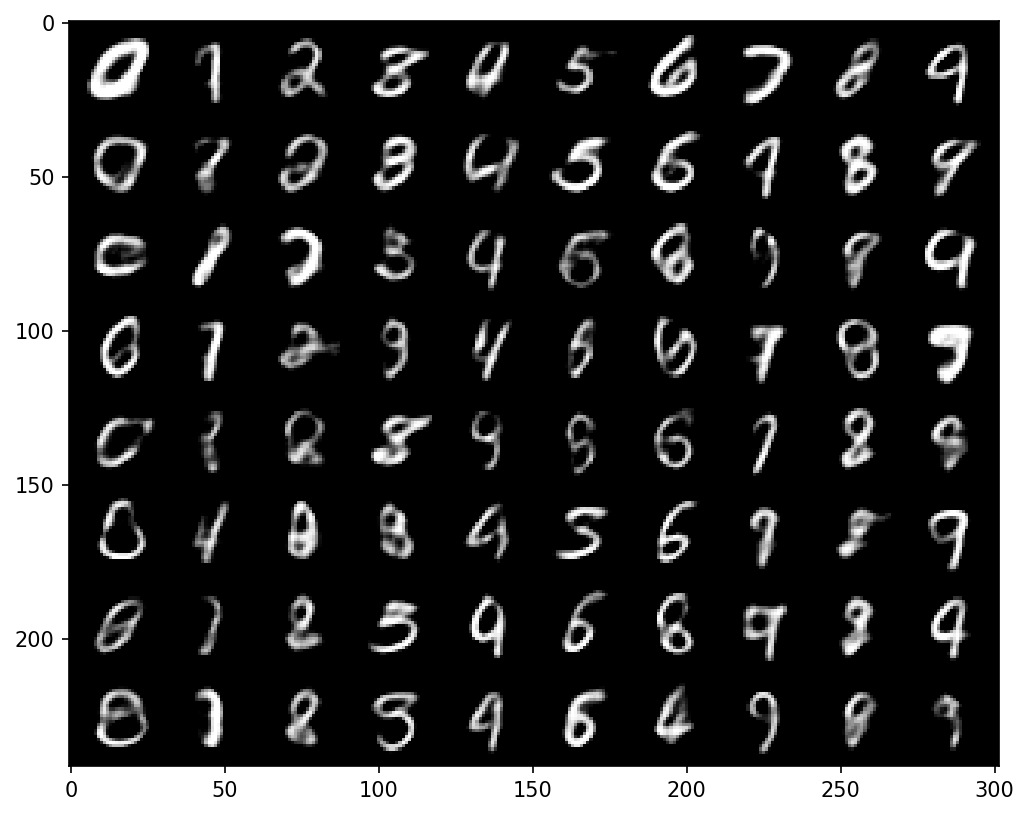

In [ ]:
show_stratified_samples(
    ambiguous_samples[indices_train],
    ambiguous_samples_evaluation.pred_entropies[indices_train],
    8,
    10,
    bin_range=[0.05, 0.8],
    predictions=ambiguous_samples_evaluation.predictions[indices_train],
    one_per_class=True,
)

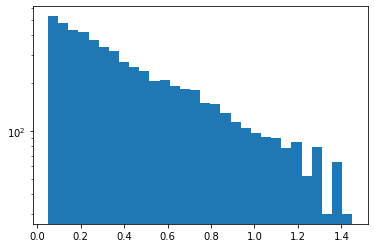

(array([524., 480., 454., 403., 373., 338., 317., 273., 254., 241., 206.,
        213., 190., 187., 165., 163., 142., 130., 113., 102., 109.,  80.,
         86.,  80.,  84.,  53.,  79.,  29.,  63.,  29.]),
 array([0.05      , 0.09666666, 0.14333333, 0.19      , 0.23666666,
        0.28333333, 0.33      , 0.37666667, 0.42333335, 0.47      ,
        0.51666665, 0.56333333, 0.61      , 0.6566667 , 0.7033333 ,
        0.75      , 0.7966667 , 0.8433333 , 0.89      , 0.93666667,
        0.98333335, 1.03      , 1.0766667 , 1.1233333 , 1.17      ,
        1.2166667 , 1.2633333 , 1.31      , 1.3566667 , 1.4033333 ,
        1.45      ], dtype=float32),
 <BarContainer object of 30 artists>)

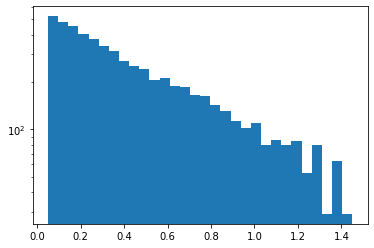

In [ ]:
plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation.pred_entropies[indices_train].numpy(),
    bins=30,
    range=[0.05, 1.45],
)
plt.show()
plt.yscale("log")
plt.hist(
    ambiguous_samples_evaluation.pred_entropies[indices_test].numpy(),
    bins=30,
    range=[0.05, 1.45],
)

In [ ]:
len(indices_train), len(indices_test)

(6049, 6028)

### Balanced Distribution per Entropy Bucket

(array([2.49480e+05, 1.75304e+05, 1.37643e+05, 1.11816e+05, 8.83720e+04,
        6.89220e+04, 5.26820e+04, 3.96690e+04, 2.97860e+04, 2.19140e+04,
        1.68370e+04, 1.25700e+04, 9.41500e+03, 7.14900e+03, 5.40800e+03,
        4.14700e+03, 3.23600e+03, 2.58700e+03, 2.08100e+03, 1.70000e+03,
        1.40200e+03, 1.20400e+03, 1.21400e+03, 1.06900e+03, 7.79000e+02,
        5.63000e+02, 4.35000e+02, 3.05000e+02, 2.06000e+02, 2.09000e+02,
        1.28000e+02, 8.40000e+01, 8.00000e+01, 5.00000e+01, 5.30000e+01,
        3.70000e+01, 2.40000e+01, 2.50000e+01, 2.00000e+01, 1.30000e+01,
        1.60000e+01, 4.00000e+00, 1.00000e+01, 6.00000e+00, 5.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([0.05 , 0.078, 0.106, 0.134, 0.162, 0.19 , 0.218, 0.246, 0.274,
        0.302, 0.33 , 0.358, 0.386, 0.414, 0.442, 0.47 , 0.498, 0.526,
        0.554, 0.582, 0.61 , 0.638, 0.666, 0.694, 0.722, 0.75 , 0.778,
        0.806, 0.834, 0.862, 0.89 , 0.918, 0.946, 0.974

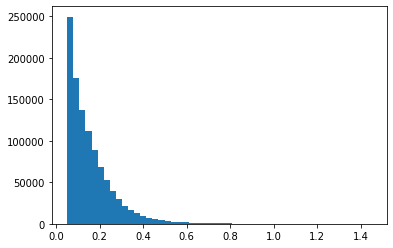

In [ ]:
plt.hist(
    ambiguous_samples_evaluation.pred_entropies.numpy(),
    bins=50,
    range=[0.05, 1.45],
)

tensor(2.2762)
tensor(2.2228)
tensor(2.1367)
tensor(1.9713)
tensor(1.8538)


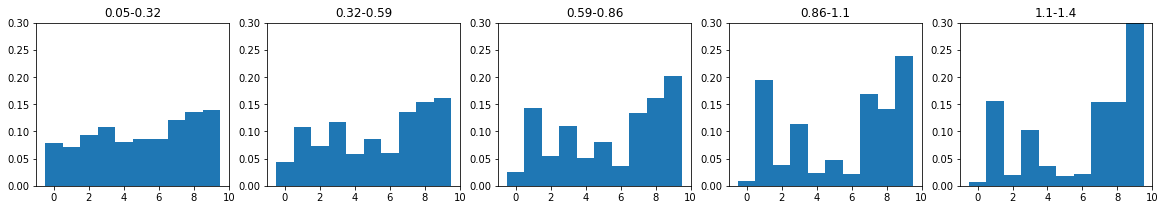

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation.pred_entropies[indices_train],
    ambiguous_samples_evaluation.predictions[indices_train],
    5,
    entropy_range=[0.05, 1.40],
)

#### Original Stratified Distribution

tensor(2.2706)
tensor(2.2236)
tensor(2.1662)
tensor(2.0025)
tensor(1.7977)


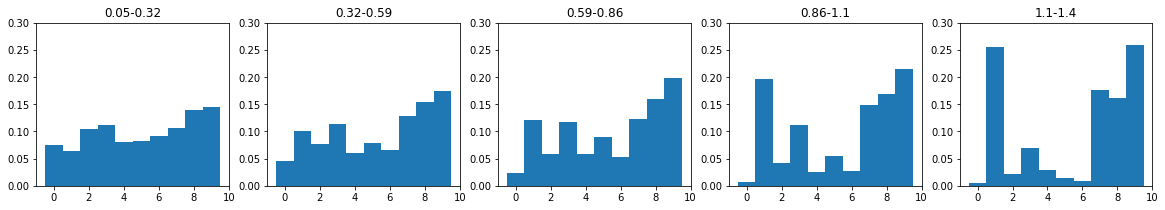

In [ ]:
show_prob_buckets(
    ambiguous_samples_evaluation.pred_entropies,
    ambiguous_samples_evaluation.predictions,
    5,
    entropy_range=[0.05, 1.40],
)

### Visualize Balanced & Stratified Samples

[[8], [1], [2], [8]]
[[6], [7], [1], [7]]
[[2], [9], [2], [0]]
[[2], [9], [5], [3]]
[[8], [2], [8], [1]]
[[8], [1], [8], [4, 9]]
[[8, 6], [8, 9], [9, 8], [7]]
[[8, 2], [4, 1], [2, 0], [5, 8]]
[[7, 1], [7, 5], [7, 9], [3, 5]]
[[1, 7], [2, 8], [7, 9], [1, 7]]


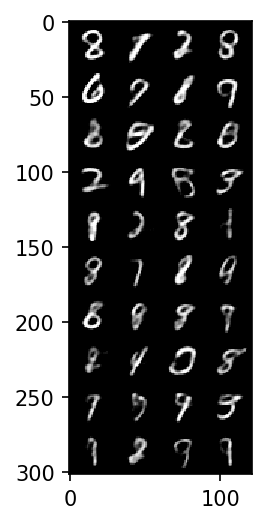

In [ ]:
show_stratified_samples(
    ambiguous_samples[indices_train],
    ambiguous_samples_evaluation.pred_entropies[indices_train],
    10,
    4,
    bin_range=[0.05, 1.0],
    predictions=ambiguous_samples_evaluation.predictions[indices_train],
)
plt.show()

### Generating Labels for Ambiguous-MNIST

We will draw 10 labels for each sample. First we will shuffle the balanced indices though.

In [ ]:
shuffled_balanced_amnist_indices_train = indices_train[torch.randperm(len(indices_train))][:6000]
shuffled_balanced_amnist_indices_test = indices_test[torch.randperm(len(indices_test))][:6000]

shuffled_balanced_amnist_indices = torch.cat(
    [shuffled_balanced_amnist_indices_train, shuffled_balanced_amnist_indices_test]
)
len(shuffled_balanced_amnist_indices)

12000

In [ ]:
amnist_predictions = ambiguous_samples_evaluation.predictions[shuffled_balanced_amnist_indices]
len(amnist_predictions)

12000

In [ ]:
def draw_labels(predictions, num_labels):
    drawn_labels = torch.multinomial(predictions, num_samples=num_labels, replacement=True)
    return drawn_labels

In [ ]:
@restore_or_create("internal_amnist_labels.pt", recreate=True)
def create_amnist_labels():
    amnist_labels = draw_labels(amnist_predictions, 10)
    return amnist_labels


amnist_labels = create_amnist_labels()

In [ ]:
amnist_samples = ambiguous_samples[shuffled_balanced_amnist_indices]
amnist_unnormalized_samples = adjusted_post_process_vae_output(amnist_samples)

In [ ]:
torch.save(amnist_predictions, "amnist_predictions.pt")
torch.save(amnist_labels, "amnist_labels.pt")
torch.save(amnist_samples, "amnist_raw_samples.pt")
torch.save(amnist_unnormalized_samples, "amnist_samples.pt")

## Evaluating DirtyMNIST and AMNIST

### Setup Datasets and DataLoaders

In [ ]:
amnist_samples = torch.load("amnist_samples.pt").expand(-1, 10, 28, 28).reshape(-1, 1, 28, 28)
amnist_labels = torch.load("amnist_labels.pt").reshape(-1)
amnist_samples.shape, amnist_labels.shape

(torch.Size([120000, 1, 28, 28]), torch.Size([120000]))

In [ ]:
amnist_normalized_samples = normalize_mnist(amnist_samples)

In [ ]:
amnist_train_dataset = torch.utils.data.TensorDataset(amnist_normalized_samples[:-60000], amnist_labels[:-60000])
amnist_test_dataset = torch.utils.data.TensorDataset(amnist_normalized_samples[-60000:], amnist_labels[-60000:])

In [ ]:
# MNIST is weird and use numpy labels, which messes up the DataLoaders
amnist_train_dataset.tensors = (
    amnist_train_dataset.tensors[0],
    amnist_train_dataset.tensors[1].numpy(),
)
amnist_test_dataset.tensors = (
    amnist_test_dataset.tensors[0],
    amnist_test_dataset.tensors[1].numpy(),
)

In [ ]:
amnist_train_loader = torch.utils.data.DataLoader(
    dataset=amnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)
amnist_test_loader = torch.utils.data.DataLoader(
    dataset=amnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

In [ ]:
dmnist_train_dataset = torch.utils.data.ConcatDataset([mnist_train_dataset, amnist_train_dataset])
dmnist_test_dataset = torch.utils.data.ConcatDataset([mnist_test_dataset, amnist_test_dataset])

In [ ]:
dmnist_train_loader = torch.utils.data.DataLoader(
    dataset=dmnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)
dmnist_test_loader = torch.utils.data.DataLoader(
    dataset=dmnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,),
            (0.3081,),
        ),
    ]
)


fmnist_train_dataset = datasets.FashionMNIST(
    root="./fmnist_data/",
    train=True,
    download=True,
    transform=transform,
)

fmnist_test_dataset = datasets.FashionMNIST(
    root="./fmnist_data/",
    train=False,
    download=True,
    transform=transform,
)

fmnist_train_loader = torch.utils.data.DataLoader(
    fmnist_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
)

fmnist_test_loader = torch.utils.data.DataLoader(
    fmnist_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)

### Training a LeNet Ensemble on DMNIST

In [ ]:
dmnist_lenets = []
num_ensemble_components = 5

for i in tqdm(range(num_ensemble_components)):

    @restore_or_create(f"dmnist_lenet_model_{i}.model", recreate=True)
    def train_lenet_model():
        lenet = LeNet(num_classes=10).cuda()
        optimizer = optim.Adam(lenet.parameters())

        best_loss = None
        best_epoch = None
        for epoch in tqdm(range(5)):  # lenet seems to converge after about 10 epochs anyways..
            lenet_train(epoch, dmnist_train_loader, optimizer, lenet)
            test_loss = lenet_test(mnist_test_loader, lenet)
            if not best_loss or best_loss > test_loss:
                torch.save(lenet.state_dict(), "./tmp_lenet_best.model")
                best_loss = test_loss
                best_epoch = epoch
                print("New best model", best_epoch, " with ", best_loss)

        print("Best epoch", best_epoch)

        lenet.load_state_dict(torch.load("./tmp_lenet_best.model"))
        return lenet

    dmnist_lenets.append(train_lenet_model())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018063
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.004648
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.004376
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.003633
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.002968
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.002271
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002596
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002990
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.003344
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.003089
====> Epoch: 0 Average loss: 0.0040
====> Test set loss: 0.0006
New best model 0  with  0.0006296385570778512
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.002271
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.003186
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.003293
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002367
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.002327
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.002287
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.002830
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018001
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.005889
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.003836
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.002937
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.002525
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.002330
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002497
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002080
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.002397
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.002385
====> Epoch: 0 Average loss: 0.0039
====> Test set loss: 0.0006
New best model 0  with  0.0005605905998439994
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.001971
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.003497
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.003803
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002289
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.002267
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.002366
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.002477
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.018015
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.004986
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.003671
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.004192
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.003000
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.003131
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.002515
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.002133
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.002812
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.003443
====> Epoch: 0 Average loss: 0.0038
====> Test set loss: 0.0005
New best model 0  with  0.0005386632391368039
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.003230
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.003479
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.002479
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002381
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.003333
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.002057
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.002264
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.017994
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.005533
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.004457
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.002608
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.003758
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.002481
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.003606
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.003567
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.001959
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.001856
====> Epoch: 0 Average loss: 0.0040
====> Test set loss: 0.0006
New best model 0  with  0.0005507850427995436
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.003087
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.002575
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.002229
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002214
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.002082
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.003609
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.003118
Train Epoch: 1 [89600/120000 (7

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/120000 (0%)]	Loss: 0.017976
Train Epoch: 0 [12800/120000 (11%)]	Loss: 0.007374
Train Epoch: 0 [25600/120000 (21%)]	Loss: 0.004855
Train Epoch: 0 [38400/120000 (32%)]	Loss: 0.004249
Train Epoch: 0 [51200/120000 (43%)]	Loss: 0.003191
Train Epoch: 0 [64000/120000 (53%)]	Loss: 0.003331
Train Epoch: 0 [76800/120000 (64%)]	Loss: 0.003032
Train Epoch: 0 [89600/120000 (75%)]	Loss: 0.003069
Train Epoch: 0 [102400/120000 (85%)]	Loss: 0.002995
Train Epoch: 0 [115200/120000 (96%)]	Loss: 0.002598
====> Epoch: 0 Average loss: 0.0042
====> Test set loss: 0.0006
New best model 0  with  0.0005878616823989432
Train Epoch: 1 [0/120000 (0%)]	Loss: 0.003279
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.002657
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.003157
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.002661
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.002810
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.002433
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.003025
Train Epoch: 1 [89600/120000 (7

### Evaluating the DMNIST LeNet Ensemble

In [ ]:
@dataclass
class Evaluation:
    predictions: torch.Tensor
    entropies: torch.Tensor
    labels: torch.Tensor

In [ ]:
@torch.no_grad()
def evaluate(test_loader, lenets):
    for lenet in lenets:
        lenet.eval()

    labels = []
    predictions = []
    with torch.no_grad():
        for data, label in tqdm(test_loader):
            data = data.cuda()
            label = label.cuda()

            batch_outputs = [lenet(data.cuda()) for lenet in lenets]
            batch_outputs = torch.stack(batch_outputs)
            batch_predictions = F.softmax(batch_outputs.mean(dim=0), dim=-1)
            predictions.append(batch_predictions)
            labels.append(label)

    labels = torch.cat(labels).cpu()
    predictions = torch.cat(predictions).cpu()
    entropies = entropy(predictions).cpu()
    return Evaluation(predictions, entropies, labels)

In [ ]:
dmnist_test_evaluation = evaluate(dmnist_test_loader, dmnist_lenets)
amnist_test_evaluation = evaluate(amnist_test_loader, dmnist_lenets)
mnist_test_evaluation = evaluate(mnist_test_loader, dmnist_lenets)
fmnist_test_evaluation = evaluate(fmnist_test_loader, dmnist_lenets)

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
print(
    "MNIST accuracy",
    (mnist_test_evaluation.predictions.argmax(dim=-1) == mnist_test_evaluation.labels).sum().item()
    / len(mnist_test_evaluation.labels)
    * 100,
)

MNIST accuracy 99.05000000000001


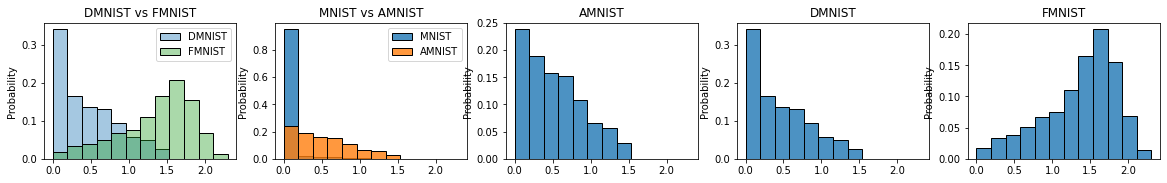

In [ ]:
import seaborn as sns


def plot_entropies(evaluation: Evaluation, **kwargs):
    # plt.ylim(0, 0.15)
    sns.histplot(evaluation.entropies.numpy(), stat="probability", binrange=[0.0, np.log(10)], bins=12, **kwargs)


plt.figure(figsize=(5 * 4, 4 / 1.6))
plt.subplot(1, 5, 1)
# plot_entropies(
#     amnist_test_evaluation,
#     alpha=0.4,
#     color=sns.color_palette()[0],
#     label="AMNIST",
# )
plot_entropies(
    dmnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[0],
    label="DMNIST",
)
# plot_entropies(
#     mnist_test_evaluation,
#     alpha=0.4,
#     color=sns.color_palette()[1],
#     label="MNIST",
# )
plot_entropies(
    fmnist_test_evaluation,
    alpha=0.4,
    color=sns.color_palette()[2],
    label="FMNIST",
)
plt.legend()
plt.title("DMNIST vs FMNIST")
plt.subplot(1, 5, 2)
plot_entropies(
    mnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="MNIST",
)
plot_entropies(
    amnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[1],
    label="AMNIST",
)
plt.title("MNIST vs AMNIST")
plt.legend()
plt.subplot(1, 5, 3)
plot_entropies(
    amnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="AMNIST",
)
plt.title("AMNIST")
plt.subplot(1, 5, 4)
plot_entropies(
    dmnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="DMNIST",
)
plt.title("DMNIST")
plt.subplot(1, 5, 5)
plot_entropies(
    fmnist_test_evaluation,
    alpha=0.8,
    color=sns.color_palette()[0],
    label="FMNIST",
)
plt.title("FMNIST")

plt.show()

This shows that training on DirtyMNIST (MNIST + Ambiguous-MNIST) will lead to predictions that correctly span a wide range of aleatoric uncertainty, causing overlaps with OOD data which is also assigned high entropy. We note that there is high overlap, even though we use a LeNet ensemble.